# Library(matplotlib or seaborn) convert to bokeh

##### tmp = visualize() 를 먼저 선언합니다.
##### 이후 tmp.'메소드 명'으로 시각화합니다.
##### bokeh의 default는 html을 띄워주는 것이나, jupyter notebook 사용자에게 맞게 jupyter 내에서 볼 수 있게 해두었습니다.
##### html로 띄우고 싶은 분들은 __init__ 부분의 output_notebook() 부분을 지우시면 됩니다.
##### 또한, html로 다운을 원하신다면, mothod의 끝에 'output_file("file 명")'을 추가하시면 됩니다.
##### 물론, jupyter 내의 이미지를 다운받는 기능도 있습니다.

In [52]:
class visualize():
    from beartype import beartype
    import pandas as pd

    @beartype
    def __init__(self, data: pd.DataFrame, width: int = 600, height: int=500):
        self.data = data
        self.width = width
        self.height = height
        self.initialize()

    def initialize(self):
        from bokeh.io import output_notebook 
        from bokeh.plotting import figure
        self.tools = "hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select"
        self.p = figure(width=self.width, height=self.height, title = None, tools=self.tools)

        output_notebook()

    @beartype
    def make_color(self, category:list):
        import random

        COLOR_SCALE = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(len(category))]
        
        return COLOR_SCALE

    @beartype
    def histogram(self, x: str, bin: int=50, line_color: str='white', fill_color: str='skyblue'):
        """
        x : x축에 들어갈 변수
        bin : 히스토그램을 몇 개의 막대로 나타낼것인지
        line_color : 히스토그램의 모서리 색상
        fill_color : 히스토그램의 안쪽 색상
        """
        data = self.data

        from bokeh.io import show
        import numpy as np

        data_x = data[x]
        p = self.p

        bins = np.linspace(int(min(data_x)),int(max(data_x)),bin)
        hist, edges = np.histogram(data_x, bins=bins)
        p.quad(top=hist,
               bottom=0,
               left=edges[:-1],
               right=edges[1:],
               fill_color=fill_color,
               line_color=line_color,)
            
        p.xaxis.axis_label= f'{x}'

        show(p)
        self.initialize()

    def kde2D(self, x: str, y: str, N: int=300):
        
        from bokeh.io import show
        from bokeh.palettes import Blues9
        import numpy as np
        from scipy.stats import gaussian_kde
        
        data = self.data
        data_x = data[x]
        data_y = data[y]
        N = N
        p = self.p
        
        xmin, xmax = data_x.min(), data_x.max()
        ymin, ymax = data_y.min(), data_y.max()

        X, Y = np.mgrid[xmin:xmax:N*1j, ymin:ymax:N*1j]
        positions = np.vstack([X.ravel(), Y.ravel()])
        values = np.vstack([data_x, data_y])
        kernel = gaussian_kde(values)
        Z = np.reshape(kernel(positions).T, X.shape)


        p.background_fill_color = "#fafafa"
        p.grid.level = "overlay"
        p.grid.grid_line_color = "black"
        p.grid.grid_line_alpha = 0.05        

        palette = Blues9[::-1]
        levels = np.linspace(np.min(Z), np.max(Z), 10)
        p.contour(X, Y, Z, levels[1:], fill_color=palette, line_color=palette)

        p.xaxis.axis_label= f'{x}'
        p.yaxis.axis_label= f'{y}'

        show(p)
        self.initialize()

    @beartype
    def bubble(self, x: str, y: str, category: str, size: str):
        
        from bokeh.io import show
        from bokeh.models import CategoricalColorMapper, ColumnDataSource, Select, CustomJS
        from bokeh.layouts import row

        data = self.data
        p = self.p
 
        factors = list(data[category].unique())

        COLOR_SCALE = self.make_color(factors)
        source = ColumnDataSource(data)
        color_mapper = CategoricalColorMapper(factors=factors, palette = COLOR_SCALE)
        
        p.circle(x=x, 
                 y=y, 
                 size=size, 
                 color={'field': category, 'transform': color_mapper}, 
                 alpha=0.9, source=source)
        
        p.xaxis.axis_label= f'{x}'
        p.yaxis.axis_label= f'{y}'
        
        options = sorted(data[category].unique())
        options.insert(0, 'All')

        category_select = Select(title='Category:', options=options)

        categories = category
        code = f'''
            var data = source.data;
            var category = cb_obj.value;
            var indices = [];
            for (var i = 0; i < data['{categories}'].length; i++) {{
                if (category == 'All' || data['{categories}'][i] == category) {{
                    indices.push(i);
                }}
            }}
            source.selected.indices = indices;
        '''

        callback = CustomJS(args=dict(source=source), code=code)
        category_select.js_on_change('value', callback)
        layout = row(category_select, p)
        show(layout)
        self.initialize()

    @beartype
    def connected_scatter(self, x: str, y: str):
        from bokeh.plotting import curdoc, show
        import pandas as pd

        p = self.p
        data = pd.DataFrame.pivot_table(self.data, values=y, index=x,aggfunc='mean').reset_index().sort_values(by=x)
        data_x = data[x]
        data_y = data[y]

        line_color = '#1B7837'

        curdoc().theme = 'caliber'
        p.line(data_x, data_y, color=line_color)
        p.circle(data_x, data_y, line_color=line_color, fill_color="white")
        p.xaxis.axis_label= f'{x}'
        p.yaxis.axis_label= f'{y}'
        show(p)
        self.initialize()

    @beartype
    def pairplot(self, category: str, target: tuple):
        from bokeh.models import ColumnDataSource, DataRange1d, Plot, LinearAxis, BasicTicker, Grid, Circle, PanTool, WheelZoomTool, ResetTool, LassoSelectTool, HoverTool
        from bokeh.transform import factor_cmap
        from bokeh.plotting import reset_output
        from bokeh.io import output_notebook 
        from bokeh.layouts import gridplot
        from bokeh.io import show
        from itertools import product

        data = self.data
        
        SPECIES = sorted(data[category].unique())
        ATTRS = target
        N = len(ATTRS)

        source = ColumnDataSource(data=data)

        xdrs = [DataRange1d(bounds=None) for _ in range(N)]
        ydrs = [DataRange1d(bounds=None) for _ in range(N)]

        plots = []

        reset_output()
        output_notebook()
        for i, (y, x) in enumerate(product(ATTRS, reversed(ATTRS))):
            p = Plot(x_range=xdrs[i%N], y_range=ydrs[i//N],
                    background_fill_color="#fafafa",
                    border_fill_color="white", width=200, height=200, min_border=5)

            if i % N == 0:  # first column
                p.min_border_left = p.min_border + 4
                p.width += 40
                yaxis = LinearAxis(axis_label=y)
                yaxis.major_label_orientation = "vertical"
                p.add_layout(yaxis, "left")
                yticker = yaxis.ticker
            else:
                yticker = BasicTicker()
            p.add_layout(Grid(dimension=1, ticker=yticker))

            if i >= N*(N-1):  # last row
                p.min_border_bottom = p.min_border + 40
                p.height += 40
                xaxis = LinearAxis(axis_label=x)
                p.add_layout(xaxis, "below")
                xticker = xaxis.ticker
            else:
                xticker = BasicTicker()
            p.add_layout(Grid(dimension=0, ticker=xticker))

            circle = Circle(x=x, y=y, fill_alpha=0.6, size=5, line_color=None,
                            fill_color=factor_cmap(f'{category}', 'Category10_3', SPECIES))
            r = p.add_glyph(source, circle)
            p.x_range.renderers.append(r)
            p.y_range.renderers.append(r)

            # suppress the diagonal
            if (i%N) + (i//N) == N-1:
                r.visible = False
                p.grid.grid_line_color = None

            p.add_tools(PanTool(), WheelZoomTool(), ResetTool(), LassoSelectTool(), HoverTool())
            plots.append(p)
        
        show(gridplot(plots, ncols=N))

        self.initialize()

    @beartype
    def heatmap(self, x: str, y: str, target: str):
        from math import pi
        from bokeh.models import BasicTicker, PrintfTickFormatter
        from bokeh.plotting import figure, show
        from bokeh.transform import linear_cmap

        data = self.data
        x_range = data[x].unique()
        y_range = data[y].unique()

        # factors = list(data[target].unique())
        # colors = self.make_color(factors)

        colors = ["#75968f", "#a5bab7", "#c9d9d3", "#e2e2e2", "#dfccce", "#ddb7b1", "#cc7878", "#933b41", "#550b1d"]

        p = figure(x_range=x_range, y_range=y_range,
                x_axis_location="above", width=self.width, height=self.height,
                tools=self.tools, toolbar_location='below')

        p.grid.grid_line_color = None
        p.axis.axis_line_color = None
        p.axis.major_tick_line_color = None
        p.axis.major_label_text_font_size = "7px"
        p.axis.major_label_standoff = 0
        p.xaxis.major_label_orientation = pi / 3

        r = p.rect(x=x, y=y, width=1, height=1, source=data,
                fill_color=linear_cmap(f'{target}', colors, low=data[target].min(), high=data[target].max()),
                line_color=None)

        p.add_layout(r.construct_color_bar(
            major_label_text_font_size="7px",
            ticker=BasicTicker(desired_num_ticks=len(colors)),
            formatter=PrintfTickFormatter(format="%d%%"),
            label_standoff=6,
            border_line_color=None,
            padding=5,
        ), 'right')

        p.xaxis.axis_label= f'{x}'
        p.yaxis.axis_label= f'{y}'

        show(p)
        self.initialize()

    @beartype
    def scatter(self, x: str, y: str, radi: str=None, color: bool=True):
        import numpy as np
        from bokeh.io import show
        data=self.data
        data_x=data[x]
        data_y=data[y]
        # radius = data[radi]
        radius = 1

        if color == False:
            colors = 'black'
        else: 
            colors = np.array([(r, g, 150) for r, g in zip(50+2*x, 30+2*y)], dtype="uint8")

        p = self.p

        p.scatter(data_x, data_y, radius=radius,
          fill_color=colors, fill_alpha=0.6,
          line_color=None)
        
        p.xaxis.axis_label= f'{x}'
        p.yaxis.axis_label= f'{y}'

        show(p)
        self.initialize()

    @beartype
    def jointplot(self, x: str, y: str):

        import holoviews as hv
        hv.extension('bokeh')

        data = self.data

        tmp = hv.Points(data[[x, y]]).hist([x, y])
        hv.output(tmp)
        self.initialize()

    @beartype
    def violin(self, x: str, y: str):
        """
        dataset : pd.DataFrame
        x : categorical 변수
        y : y축에 들어갈 변수
        """
        dataset = self.data

        import scipy.stats as st
        import matplotlib.pyplot as plt
        import numpy as np
        # import random

        species_ = sorted(dataset[x].unique())
        y_data = [dataset[dataset[x] == specie][y].values for specie in species_]

        jitter = 0.04
        x_data = [np.array([i] * len(d)) for i, d in enumerate(y_data)]
        x_jittered = [x + st.t(df=6, scale=jitter).rvs(len(x)) for x in x_data]

        POSITIONS = list(range(len(species_)))
        # COLOR_SCALE = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(len(species_))]
        COLOR_SCALE = self.make_color(species_)
        BLACK = "#282724"
        GREY_DARK = "#747473"
        RED_DARK = "#850e00"

        fig, ax = plt.subplots(figsize= (14, 10))
        violins = ax.violinplot(
            y_data, 
            positions=POSITIONS,
            widths=0.45,
            bw_method="silverman",
            showmeans=False, 
            showmedians=False,
            showextrema=False
        )

        for pc in violins["bodies"]:
            pc.set_facecolor("none")
            pc.set_edgecolor(BLACK)
            pc.set_linewidth(1.4)
            pc.set_alpha(1)

        medianprops = dict(
            linewidth=4, 
            color=GREY_DARK,
            solid_capstyle="butt"
        )
        boxprops = dict(
            linewidth=2, 
            color=GREY_DARK
        )

        ax.boxplot(
            y_data,
            positions=POSITIONS, 
            showfliers = False, # 이상치 표시x
            showcaps = False,   # 캡표시x
            medianprops = medianprops,
            whiskerprops = boxprops,
            boxprops = boxprops
        )

        for x, y, color in zip(x_jittered, y_data, COLOR_SCALE):
            ax.scatter(x, y, s = 100, color=color, alpha=0.7)

        means = [y.mean() for y in y_data]
        for i, mean in enumerate(means):
            ax.scatter(i, mean, s=250, color=RED_DARK, zorder=3)

            ax.plot([i, i + 0.25], [mean, mean], ls="dashdot", color="black", zorder=3)
            
            ax.text(
                i + 0.25,
                mean,
                r"$\hat{\mu}_{\rm{mean}} = $" + str(round(mean, 2)),
                fontsize=13,
                va="center",
                bbox = dict(
                    facecolor="white",
                    edgecolor="black",
                    boxstyle="round",
                    pad=0.15 
                ),
                zorder=10 
            )


        xlabels = [f"{specie}\n(n={y_data[i].size})" for i, specie in enumerate(species_)]
        ax.set_xticks(POSITIONS)
        ax.set_xticklabels(xlabels, size=15, ha="center", ma="center")

        plt.show()
        
    @beartype
    def violin_split(self, x: str, y: str, hue: str=None, cmap: str=None, number: int=None, linewidth: float=.1, figsize: tuple=(10,3), violin_cmap: list=['gold','orange'], title: str=None):
        """
        dataset : pd.DataFrame
        x : categorical 변수
        y : y축에 들어갈 변수
        hue : violin 좌/우 
        cmap : matplotlib의 palette이며, 자세한 내용은 'https://matplotlib.org/stable/users/explain/colors/colormaps.html'을 참고
        number : 강조하고 싶은 violin 순서
        linewidth : 선 두께
        figsize : figure size
        violin_cmap : number의 violin 좌/우 색상
        title : 제목

        """

        dataset = self.data

        import seaborn as sns
        import matplotlib.pyplot as plt

        sns.set_context("talk")
        sns.set_style("white")

        fig, ax = plt.subplots(figsize=figsize, constrained_layout=True)
        sns.violinplot(data=dataset, x=x, y=y, ax=ax,
                    color=cmap, hue=hue, split=True, palette=cmap, linewidth=linewidth)
        
        number = number
        v_left_color = violin_cmap[0]
        v_right_color = violin_cmap[1]

        # 바이올린의 왼쪽부분
        violins_Left = [c for i, c in enumerate(ax.collections) if i%2 == 0]  
        [v.set_edgecolor("gray") for v in violins_Left]
        [v.set_linewidth(1) for v in violins_Left]
        violins_Left[number].set_facecolor(v_left_color)    # facecolor 변경
        violins_Left[number].set_linewidth(1)               # line 굵기 변경
        violins_Left[number].set_edgecolor("k")             # edgecolor 변경

        # 바이올린의 오른쪽부분
        violins_Right = [c for i, c in enumerate(ax.collections) if i%2 == 1]
        [v.set_edgecolor("gray") for v in violins_Right]
        [v.set_linewidth(1) for v in violins_Right]
        violins_Right[number].set_facecolor(v_right_color)  # facecolor 변경
        violins_Right[number].set_linewidth(1)              # line 굵기 변경
        violins_Right[number].set_edgecolor("k")            # edgecolor 변경

        # 바이올린의 마커부분
        # markers = [c for i, c in enumerate(ax.lines) if i%3 == 1]
        # markers[number].set_facecolor("w")         # facecolor 변경
        # markers[number].set_edgecolor("k")         # edgecolor 변경
        # [m.set_sizes([50]) for m in markers]  # 전체 median size 변경

        # box-whisker: Line2D
        ls = [l for i, l in enumerate(ax.lines)]
        ls[number*2].set_color("k")                 # whisker 색상 변경
        ls[number*2+1].set_color("k")                 # box 색 변경
        [l.set_linewidth(1) for i, l in enumerate(ls) if i%2 == 0] # 전체 box, whisher 굵기 변경
        [l.set_linewidth(5) for i, l in enumerate(ls) if i%2 == 1] # 전체 box, whisher 굵기 변경

        # # spines 제거, grid 추가, xlabel 제거, ylabel 제거
        ax.set_ylim()
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_title(title)
        ax.spines[["left", "top", "right"]].set_visible(False)
        ax.grid(axis="y", lw=1)
        legend = ax.legend()
        legend.remove()
        fig.legend(loc="upper right", ncol=2)
        
        plt.show()

    @beartype
    def histo_split(self, x: str, y: str, bin: int=30):
        """
        dataset : pd.DataFrame
        x : x축 위에 들어갈 변수
        y : x축 아래에 들어갈 변수
        bins : 막대기 개수
        """

        from bokeh.io import show
        import numpy as np

        p = self.p
        dataset = self.data
        data_x = dataset[x]
        data_y = dataset[y]
                
        bins = np.linspace(int(min(data_x)),int(max(data_x)),bin)
        hist, edges = np.histogram(data_x, bins=bins)
        p.quad(top=hist,
                bottom=0,
                left=edges[:-1],
                right=edges[1:],
                fill_color='skyblue',
                line_color='white')

        bins_ = np.linspace(int(min(data_y)),int(max(data_y)),bin)
        hist, edges = np.histogram(data_y, bins=bins_)
        hist_ = hist * -1
        p.quad(top=0,
                bottom=hist_,
                left=edges[:-1],
                right=edges[1:],
                fill_color='orange',
                line_color='white')
        show(p)
        self.initialize()

    @beartype
    def density_split(self, x: str, y: str, fill: bool=True):
        """
        dataset : pd.DataFrame
        x : x축 위에 들어갈 변수
        y : x축 아래에 들어갈 변수
        fill : line과 x축 사이 채우기
        """

        dataset = self.data

        import seaborn as sns
        import matplotlib.pyplot as plt
        from scipy.stats import gaussian_kde
        from numpy import linspace
        
        sns.kdeplot(data=dataset, x=x, fill=fill, alpha=.5)

        # plot density chart for var2
        kde = gaussian_kde(dataset[y])
        x_range = linspace(min(dataset[y]), max(dataset[y]), len(dataset[y]))

        # multiply by -1 to reverse axis (mirror plot)
        sns.lineplot(x=x_range*-1, y=kde(x_range) * -1, color='orange') 
        plt.fill_between(x_range*-1, kde(x_range) * -1, color='orange', alpha = .5)

        plt.axhline(y=0, linestyle='-',linewidth=1, color='black')
        plt.xlabel("")
        plt.show()

    @beartype
    def histogram_four(self, x: str, y: str):
        """
        dataset : pd.DataFrame
        x : category
        y : y축에 올 변수, continuous

        ['layer', 'dodge', 'stack', 'fill'] 총 4가지의 histogram을 보여줌
        """

        dataset = self.data

        import matplotlib.pyplot as plt
        import seaborn as sns

        fig, ax = plt.subplots(2,2)
        fig.set_size_inches((16,16))
        multiple_list = ['layer', 'dodge', 'stack', 'fill']
        for i in range(4):
            row = i//2
            col = i%2
            cur_ax = ax[row, col]
            sns.histplot(data=dataset, x=y,
                            hue=x,
                            hue_order=list(dataset[x].unique()),
                            palette='cool', ## 컬러맵 지정
                            multiple=multiple_list[i], ## 여러 히스토그램 그리는 방식
                            ax=cur_ax,
                            ) 
            cur_ax.set_title(multiple_list[i])
        plt.tight_layout()
        plt.show()


    def ridgeline(self):
        import colorcet as cc
        from numpy import linspace
        from scipy.stats import gaussian_kde
        from bokeh.models import ColumnDataSource
        from bokeh.plotting import figure, show

        data = self.data

        def ridge(category, data, scale=20):
            return list(zip([category]*len(data), scale*data))

        cats = list(reversed(data.keys()))

        palette = [cc.rainbow[i*15] for i in range((len(data.keys())))]
        min = data.min().min()
        max = data.max().max()
        x = linspace(min, max, 500)

        source = ColumnDataSource(data=dict(x=x))

        p = figure(y_range=cats, tools=self.tools)

        for i, cat in enumerate(reversed(cats)):
            pdf = gaussian_kde(data[cat])
            y = ridge(cat, pdf(x))
            source.add(y, cat)
            p.patch('x', cat, color=palette[i], alpha=0.6, line_color="black", source=source)

        p.outline_line_color = None
        p.background_fill_color = "#efefef"

        p.ygrid.grid_line_color = None
        p.xgrid.grid_line_color = "#dddddd"
        p.xgrid.ticker = p.xaxis.ticker

        p.axis.minor_tick_line_color = None
        p.axis.major_tick_line_color = None
        p.axis.axis_line_color = None

        show(p)
        self.initialize()

    @beartype
    def area_stack(self, perc: bool = False):
        from bokeh.palettes import viridis
        from bokeh.plotting import figure, show

        import warnings

        warnings.filterwarnings('ignore')

        data = self.data
        num_list = list(tmp[(tmp['var_type']=='int') | (tmp['var_type']=='float')]['col_nm'].values)
        
        def percent(data):
            N = len(data.columns)

            p = figure(x_range=(0, len(data)-1), tools=self.tools)
            p.grid.minor_grid_line_color = '#eeeeee'

            # names = data.keys().to_list()
            names = num_list
            p.varea_stack(stackers=names, x='index', color=viridis(N), legend_label=names,  source=data)

            p.legend.orientation = "vertical"
            p.legend.background_fill_color = "#fafafa"

            show(p)

        data_01 = data[num_list]
        if perc ==True:
            for i in range(len(data_01)):
                data_01.loc[i]=data_01.loc[i] / data_01.sum(axis=1).to_list()[i]
            percent(data_01)
        else:
            percent(data_01)
        
        self.initialize()

    @beartype
    def chord(self, size: int = 300, cmap: str = 'Category20'):
        import holoviews as hv
        from holoviews import opts, dim

        hv.extension('bokeh')
        hv.output(size=size)

        data = self.data

        links = data[['source','target','value']].dropna()
        nodes = hv.Dataset(data[['name','group']].dropna(),'index')

        chord = hv.Chord((links, nodes)).select(value=(5, None))
        chord.opts(
            opts.Chord(cmap=cmap, edge_cmap=cmap, edge_color=dim('source').str(), 
                    labels='name', node_color=dim('index').str()))
        
        hv.output(chord)
        self.initialize()

    @beartype
    def pydeck_count(self, x: str):
        """
        dataset : geojson 경로를 입력
        x : 보이고자하는 변수, continuous

        구역 별 count 보기에 용이
        """

        dataset = self.data

        import pydeck as pdk
        import geopandas as gpd
        import pandas as pd
        import json
        
        df = gpd.read_file(dataset)

        if json.load(open(dataset, encoding='utf-8'))['features'][0]['geometry']['type'] == 'MultiPolygon':
            # pydeck은 geometry 컬럼의 shapely.geometry.multipolygon 타입을 읽지 못하여 아래와 같이 변경하는 작업을 해줌
            # multipolygon을 polygon들로 변경 후 진행하여야 함

            df['polygons'] = df['geometry'].apply(lambda x : list(x.geoms))

            def polygon_to_coordinates(x):
                lon, lat = x[0].exterior.xy
                return [[x, y] for x, y in zip(lon, lat)]

            df['coordinates'] = df['polygons'].apply(polygon_to_coordinates)
            del df['geometry']
            del df['polygons']
        else:
            df['coordinates'] = df['geometry']
            del df['geometry']

        df['norm_x'] = df[x] / df[x].max()

        df = pd.DataFrame(df)

        layer = pdk.Layer(
        'PolygonLayer', # 사용할 Layer 타입
        df, # 시각화에 쓰일 데이터프레임
        extruded = True,
        get_elevation = x,
        elevation_scale = 0.05,
        get_polygon='coordinates', # geometry 정보를 담고있는 컬럼 이름
        get_fill_color='[0, 255*norm_x, 0]', # 각 데이터 별 rgb 또는 rgba 값 (0~255)
        pickable=True, # 지도와 interactive 한 동작 on
        auto_highlight=True # 마우스 오버(hover) 시 박스 출력
        )
        
        # Set the viewport location
        center = [126.986, 37.565]
        view_state = pdk.ViewState(
            longitude=center[0],
            latitude=center[1],
            zoom=10)
        
        view_state.bearing=15
        view_state.pitch=45

        r = pdk.Deck(layers=[layer], initial_view_state=view_state)

        display(r.to_html())

    @beartype
    def pydeck_distribution(self, center: list=[126.986, 37.565]):
        """
        dataset : geojson 경로
        center : 지도 데이터 중심, default 서울
        """

        dataset = self.data

        import pydeck as pdk
        
        layer_list = ['ScatterplotLayer', 'HeatmapLayer', 'CPUGridLayer']

        for lay in layer_list:
            layer = pdk.Layer(
                lay,
                dataset,
                get_position='[X_WGS84, Y_WGS84]',
                get_radius=50,
                get_fill_color='[255, 255, 255]',
                pickable=True,
                auto_highlight=True
            )

            center = center
            view_state = pdk.ViewState(
                longitude=center[0],
                latitude=center[1],
                zoom=10)

            r = pdk.Deck(layers=[layer], initial_view_state=view_state)

            display(r)

    @beartype
    def pydeck_connection(dataset_01: pd.DataFrame, dataset_02: pd.DataFrame):
        """
        dataset_01 : A -> B one-side
        dataset_02 : B -> A one-side
        
        dataset's col_names : ['start_id', 'end_id', 'start_lng', 'start_lat', 'end_lng', 'end_lat'] 으로 되어야 함
        """
        import pydeck as pdk

        layer = pdk.Layer(
            'ArcLayer',
            dataset_01,
            get_source_position='[start_lng, start_lat]',
            get_target_position='[end_lng, end_lat]',
            get_source_color='[255, 255, 120]',
            get_target_color='[255, 255, 120]',
            pickable=True,
            auto_highlight=True
        )

        layer2 = pdk.Layer(
            'ArcLayer',
            dataset_02,
            get_source_position='[start_lng, start_lat]',
            get_target_position='[end_lng, end_lat]',

            get_source_color = '[120,255,255]',
            get_target_color = '[120,255,255]',

            pickable=True,
            auto_highlight=True
        )

        view_state = pdk.data_utils.compute_view(dataset_01[['start_lng', 'start_lat']].values)
        view_state.zoom = 12
        view_state.bearing = -15
        view_state.pitch = 45

        r = pdk.Deck(layers=[layer, layer2], initial_view_state=view_state)
        display(r.to_html())


    # http://data.nsdi.go.kr/dataset/20171206ds00001


    @beartype
    def pie(self,x: str, y: str):
        from math import pi
        from bokeh.palettes import Category20c
        from bokeh.plotting import show
        from bokeh.transform import cumsum

        data = self.data[[x,y]]
        p = self.p

        data['angle'] = data[y]/data[y].sum() * 2*pi
        data['color'] = Category20c[len(data)]

        p.wedge(x=0, y=1, radius=0.4,
                start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
                line_color="white", fill_color='color', legend_field=x, source=data)

        p.axis.axis_label = None
        p.axis.visible = False
        p.grid.grid_line_color = None

        show(p)
        self.initialize()

    @beartype
    def donut(self, x: str, y: str):
        from math import pi
        from bokeh.io import show
        from bokeh.models import (AnnularWedge, ColumnDataSource, Legend, LegendItem, Range1d)
        from bokeh.palettes import viridis
        data = self.data

        xdr = Range1d(start=-2, end=2)
        ydr = Range1d(start=-2, end=2)

        p = self.p
        p.x_range = xdr
        p.y_range = ydr

        aggregated = data.groupby(x).sum(numeric_only=True)
        selected = aggregated[aggregated[y] >= 1].copy()
        selected.loc["Other"] = aggregated[aggregated[y] < 1].sum()
        browsers = selected.index.tolist()

        colors = dict(zip(browsers, viridis(len(browsers))))

        angles = selected.Share.map(lambda x: 2*pi*(x/100)).cumsum().tolist()

        browsers_source = ColumnDataSource(dict(
            start  = [0] + angles[:-1],
            end    = angles,
            colors = [colors[browser] for browser in browsers],
        ))

        glyph = AnnularWedge(x=0, y=0, inner_radius=0.9, outer_radius=1.8,
                            start_angle="start", end_angle="end",
                            line_color="white", line_width=3, fill_color="colors")
        
        r= p.add_glyph(browsers_source, glyph)
        
        legend = Legend(location="right")
        for i, name in enumerate(colors):
            legend.items.append(LegendItem(label=name, renderers=[r], index=i))
        
        p.add_layout(legend, "right")

        show(p)
        self.initialize()

    @beartype
    def venn_(self, x: str):
        """
        dataset : pd.DataFrame
        x : 원하는 컬럼명

        """

        dataset = self.data

        from venn import venn
        target = {}
        for i in range(len(dataset)):
            temp_01 = dataset.index[i]
            temp_02 = dataset[dataset.columns[x]][i]
    
            target[temp_01] = temp_02

        venn(target)
        
    @beartype
    def mosaic_(self, cmap: str='summer'):
        """
        dataset : pd.DataFrame
        cmap : matplotlib의 palette이며, 자세한 내용은 'https://matplotlib.org/stable/users/explain/colors/colormaps.html'을 참고

        BK 요청으로 만든 시각화
        """

        import itertools
        import matplotlib.pyplot as plt
        from statsmodels.graphics.mosaicplot import mosaic

        dataset = self.data

        tmp_list = []
        for i in range(len(dataset.columns)):
            tmp_list.append(list(set(dataset[dataset.columns[i]])))
            
        tmp_01 = list(itertools.product(*tmp_list))
        num_categories = len(tmp_01)

        cmap = plt.get_cmap(cmap)
        category_colors = [cmap(i / num_categories) for i in range(num_categories)]

        props = {}
        for i in range(num_categories):
            props[tmp_01[i]] = {'color':category_colors[i]}

        mosaic_data = dataset.groupby(list(dataset.columns)).size().unstack().fillna(0)
        mosaic(mosaic_data.stack(), gap=0.05, properties=props)

        plt.show()

    @beartype
    def mixed(self, box: str, line: str):
        from bokeh.models import FactorRange
        from bokeh.palettes import TolPRGn4
        from bokeh.plotting import show, figure

        data = self.data
        idx = data.index
        box = data[box]
        line = data[line]

        p = figure(x_range = FactorRange(*idx), width=self.width, height=self.height, title = None, tools=self.tools)

        fill_color, line_color = TolPRGn4[2:]


        p.vbar(x=idx, top=box, width=0.8,
            fill_color=fill_color, fill_alpha=0.8, line_color=line_color, line_width=1.2)

        p.line(x=idx, y=line, color=line_color, line_width=3)
        p.circle(x=idx, y=line, size=10,
                line_color=line_color, fill_color="white", line_width=3)

        p.y_range.start = 0
        p.x_range.range_padding = 0.1
        p.xaxis.major_label_orientation = 1
        p.xgrid.grid_line_color = None

        show(p)
        self.initialize()

    @beartype
    def circular(self, target: str, value: str, group: str):
        """
        dataset : pd.DataFrame
        target : label 컬럼명
        value : value 컬럼명
        group : group 컬럼명
        """

        dataset = self.data

        import matplotlib.pyplot as plt
        import numpy as np

        def get_label_rotation(angle, offset):
            rotation = np.rad2deg(angle + offset)
            if angle <= np.pi:
                alignment = "right"
                rotation = rotation + 180
            else: 
                alignment = "left"
            return rotation, alignment
        
        def add_labels(angles, values, labels, offset, ax):
            # 라벨이랑 막대 사이에 공간
            padding = 4
            
            # 각도, 값, 라벨에 값 추가
            for angle, value, label, in zip(angles, values, labels):
                angle = angle
                
                # 텍스트 회전해서 가져오기
                rotation, alignment = get_label_rotation(angle, offset)
                ax.text(
                    x=angle, 
                    y=value + padding, 
                    s=label, 
                    ha=alignment, 
                    va="center", 
                    rotation=rotation, 
                    rotation_mode="anchor"
                ) 

        VALUES = dataset[value].values
        LABELS = dataset[target].values
        GROUP = dataset[group].values
        OFFSET = np.pi / 2
        PAD = len(set(dataset[group].values)) - 1
        ANGLES_N = len(VALUES) + PAD * len(np.unique(GROUP))
        ANGLES = np.linspace(0, 2 * np.pi, num=ANGLES_N, endpoint=False)
        WIDTH = (2 * np.pi) / len(ANGLES)
        LENGTH = len(dataset)
        offset = 0
        IDXS = []
        GROUPS_SIZE = dataset[group].value_counts(sort=False).to_list()
        LIM=round(max(dataset['value']), -len(str(max(dataset['value']))))
        
        for size in GROUPS_SIZE:
            IDXS += list(range(offset + PAD, offset + size + PAD))
            offset += size + PAD

        fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": "polar"})
        ax.set_theta_offset(OFFSET)
        ax.set_ylim(-LIM, LIM)
        ax.set_frame_on(False)
        ax.xaxis.grid(False)
        ax.yaxis.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])

        COLORS = [f"C{i}" for i, size in enumerate(GROUPS_SIZE) for _ in range(size)]

        ax.bar(
            ANGLES[IDXS], VALUES, width=WIDTH, color=COLORS, 
            edgecolor="white", linewidth=2
        )

        add_labels(ANGLES[IDXS], VALUES, LABELS, OFFSET, ax)

        # 그룹 넣기
        offset = 0 
        for grp, size in zip(sorted(list(set(dataset[group]))), GROUPS_SIZE):

            x1 = np.linspace(ANGLES[offset + PAD], ANGLES[offset + size + PAD - 1], num=LENGTH)
            ax.plot(x1, [-5] * LENGTH, color="#333333")
            
            ax.text(
                np.mean(x1), -LIM*.2, grp, color="#333333", fontsize=14, 
                fontweight="bold", ha="center", va="center"
            )
            

            x2 = np.linspace(ANGLES[offset], ANGLES[offset + PAD - 1], num=LENGTH)
            ax.plot(x2, [LIM*.2] * LENGTH, color="#bebebe", lw=0.8)
            ax.plot(x2, [LIM*.4] * LENGTH, color="#bebebe", lw=0.8)
            ax.plot(x2, [LIM*.6] * LENGTH, color="#bebebe", lw=0.8)
            ax.plot(x2, [LIM*.8] * LENGTH, color="#bebebe", lw=0.8)
            
            offset += size + PAD
        
        plt.show()
    
    @beartype
    def min2max(self, min_: str, max_: str, target: str):
        """
        dataset : pd.DataFrame
        min_ : min 값 컬럼명
        max_ : max 값 컬럼명
        target : label 컬럼명
        """

        tmp_data = self.data
        dataset = tmp_data.copy()


        import matplotlib.pyplot as plt
        import matplotlib.colors as mc
        from palettable import cartocolors

        dataset['diff'] = dataset[max_].array - dataset[min_].array

        fig, ax = plt.subplots(figsize = (15, 10))

        norm_diff = mc.Normalize(vmin=0, vmax=round(max(dataset['diff'].values),-1))
        colormap = cartocolors.sequential.TealGrn_7.mpl_colormap
        color = colormap(norm_diff(dataset['diff'].values))
        ax.hlines(y=target, xmin=min_, xmax=max_, color=color, lw=5, data=dataset)
        DARK_BLUE = "#242c3c"
        ax.scatter(x=min_, y=target, s=160, color=color, edgecolors=color, lw=2, zorder=2, data=dataset)
        ax.scatter(x=max_, y=target, s=200, color=DARK_BLUE, edgecolors=DARK_BLUE, lw=2.5, zorder=2, data=dataset)
        
        fig.patch.set_facecolor("#FFFCFC")

        plt.show()

    @beartype
    def radar(self, drop: str=None):
        """
        dataset : pd.DataFrame
        drop : dataset의 group 컬럼

        ex)
        df = pd.DataFrame({
        'group': ['A','B','C','D'],
        'var1': [38, 1.5, 30, 4],
        'var2': [29, 10, 9, 34],
        'var3': [8, 39, 23, 24],
        'var4': [7, 31, 33, 14],
        'var5': [28, 15, 32, 14]
        })
        """

        import matplotlib.pyplot as plt
        import itertools
        from math import pi
        from matplotlib.spines import Spine
        from matplotlib.path import Path
        from matplotlib.transforms import Affine2D

        dataset = self.data

        categories=list(dataset)[1:]
        N = len(categories)

        values=dataset.loc[0].drop(drop).values.flatten().tolist()
        values += values[:1]
        
        angles = [n / float(N) * 2 * pi for n in range(N)]
        angles += angles[:1]

        ax = plt.subplot(111, polar=True)

        ax.set_theta_offset(pi / 2)
        ax.set_theta_direction(-1)

        plt.xticks(angles[:-1], categories)
    
        a = []
        for i in range(len(dataset)):
            a.append(dataset.loc[i].drop(drop).values.flatten().tolist())

        max_ = max(list(itertools.chain(*a)))
        rounded_ = round(max_,-len(str(int(round(max_,-1))))+1)
        tmp_list = [round(rounded_*.25,1),round(rounded_*.5,1),round(rounded_*.75,1)]

        ax.set_rlabel_position(0)
        plt.yticks(tmp_list, [str(int(tmp_list[0])),str(int(tmp_list[1])),str(int(tmp_list[2]))], color="grey", size=7)
        plt.xticks(fontsize=20, fontweight='bold')
        plt.ylim(0,rounded_)

        # 각각 25%, 50%, 75%에 다각형으로 line graph 그리기
        ax.plot(angles, [int(tmp_list[0])]*(N+1), color='grey', linewidth=.5, linestyle='--')
        ax.plot(angles, [int(tmp_list[1])]*(N+1), color='grey', linewidth=.5, linestyle='--')
        ax.plot(angles, [int(tmp_list[2])]*(N+1), color='grey', linewidth=.5, linestyle='--')

        for i in range(len(dataset)):
            values=dataset.loc[i].drop(drop).values.flatten().tolist()
            g_nm = dataset[drop][i]
            values += values[:1]
            ax.plot(angles, values, linewidth=1, linestyle='dashdot', label=f"{g_nm}") # linestyle : dashed, solid, dashdot, dotted --> '-' / '--' / '-.' / ':'
            
            ax.tick_params(axis='x', which='major', pad=15)
            ax.fill(angles, values, alpha=0.1)

        spine = Spine(axes=ax,
                spine_type='circle',
                path=Path.unit_regular_polygon(len(categories)))

        ## Axes의 중심과 반지름을 맞춰준다.
        spine.set_transform(Affine2D().scale(.5).translate(.5, .5)+ax.transAxes)
        
        ax.spines = {'polar':spine} ## frame의 모양을 원에서 폴리곤으로 바꿔줘야한다.
        
        # 그리드 선 설정
        for g in ax.yaxis.get_gridlines():
            g.set_visible(False)
            
        plt.legend(loc='upper right', bbox_to_anchor=(1.2,1.2))
        plt.show()

# wordcloud 1.9.2 패키지(latest)는 [3.7, 3.8, 3.9, 3.10, 3.11.] 버전에서만 설치됨
    @beartype
    def wordcloud(text: str, img_path: str):
        """
        text : str 형태의 문장 변수
        img_path : image 경로
        """

        from wordcloud import WordCloud, ImageColorGenerator
        import matplotlib.pyplot as plt
        import numpy as np
        from PIL import Image

        icon = Image.open(img_path)

        mask = Image.new("RGB", icon.size, (255,255,255))
        mask.paste(icon, icon)
        mask = np.array(mask)

        wordcloud = WordCloud(mask=mask,
                            width=800, height=600,
                            min_font_size=1,
                            background_color='white',
                            max_words=1000
                            ).generate(text)
        plt.figure(figsize=(16,9))
        plt.axis("off")
        plt.margins(x=0, y=0)
        image_colors = ImageColorGenerator(mask)
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation='bilinear')

In [53]:
viz_params_type = {'histogram' : {'x':'num'},
                   'kde2D' : {'x':'num','y':'num'},
                   'bubble' : {'x':'num','y':'num','category':'category','size':'num'},
                   'connected_scatter' : {'x':'num','y':'num'},
                   'pairplot' : {'category':'category','target':'category'},
                   'heatmap' : {'x':'category','y':'category','target':'num'},
                #    'scatter' : {'x':'num','y':'num', 'radi':'num'},
                   'scatter' : {'x':'num','y':'num'},
                   'jointplot' : {'x':'num','y':'num'},
                   'violin' : {'x':'category','y':'num'},
                   'violin_split' : {'x':'category','y':'num','hue':'category'},
                   'histo_split' : {'x':'num','y':'num'},
                   'density_split' : {'x':'num','y':'num'},
                   'histogram_four' : {'x':'category','y':'num'},
                   'pie' : {'x':'category','y':'num'},
                   'donut' : {'x':'category','y':'num'},
                   'mixed' : {'box':'num','line':'num'},
                   'circular' : {'target':'category','value':'num','group':'category'},
                   'min2max' : {'min_':'num','max_':'num','target':'category'},
                   'area_stack' : {}}


In [54]:
import pandas as pd
def check_type(data: pd.DataFrame):
    var_int = ['int64','int32','int16','int8','uint64','uint32','uint16','uint8']
    var_float = ['float64','float32']
    var_date = ['datetime64', 'timedelta64']
    var_cate = ['O','category']
    var_bool = ['bool']

    tmp = pd.DataFrame(data.dtypes)
    tmp.rename(columns={0:'type'}, inplace=True)
    tmp['var_type'] = 0
    for i in range(len(tmp)):
        if tmp['type'][i] in var_int:
            tmp['var_type'][i] = 'int'
        elif tmp['type'][i] in var_float:
            tmp['var_type'][i] = 'float'
        elif tmp['type'][i] in var_date:
            tmp['var_type'][i] = 'date'
        elif tmp['type'][i] in var_cate:
            tmp['var_type'][i] = 'category'
        elif tmp['type'][i] in var_bool:
            tmp['var_type'][i] = 'bool'

    tmp.reset_index(drop=False, inplace=True)
    tmp.rename(columns={'index':'col_nm'}, inplace=True)

    return tmp

In [55]:
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
tips = sns.load_dataset('tips')
iris = sns.load_dataset('iris')

In [56]:
tmp = check_type(iris)
test=visualize(iris)

Loading BokehJS ...

In [57]:
func_list = ['histogram','kde2D','bubble','connected_scatter','pairplot',
             'heatmap','scatter','jointplot','violin','violin_split',
             'histo_split','density_split','histogram_four','pie',
             'donut','mixed','circular','min2max', 'area_stack']

Loading BokehJS ...

histogram


Loading BokehJS ...

kde2D


Loading BokehJS ...

bubble


Loading BokehJS ...

connected_scatter


Loading BokehJS ...

heatmap


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
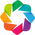

:AdjointLayout
   :Points   [petal_width,sepal_length]
   :Histogram   [sepal_length]   (sepal_length_count)
   :Histogram   [petal_width]   (petal_width_count)

Loading BokehJS ...

jointplot


<Figure size 640x480 with 0 Axes>

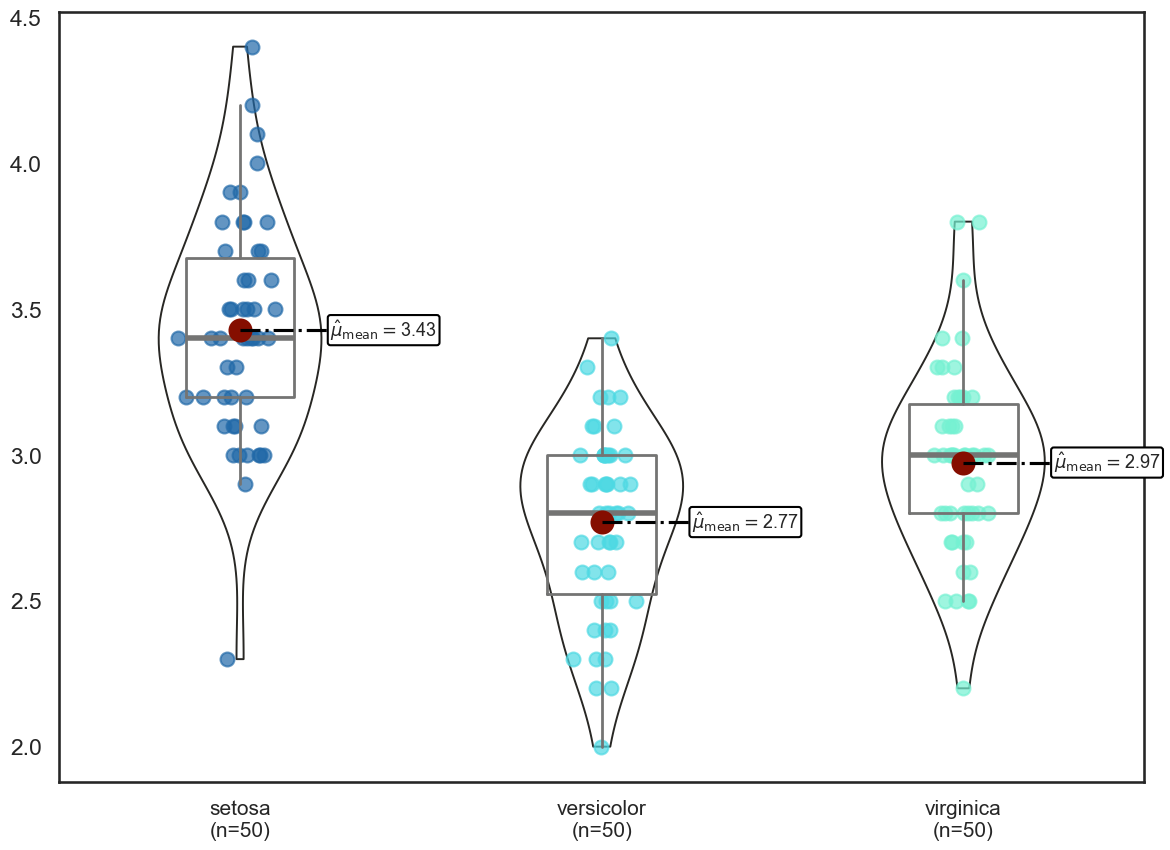

violin


Loading BokehJS ...

histo_split


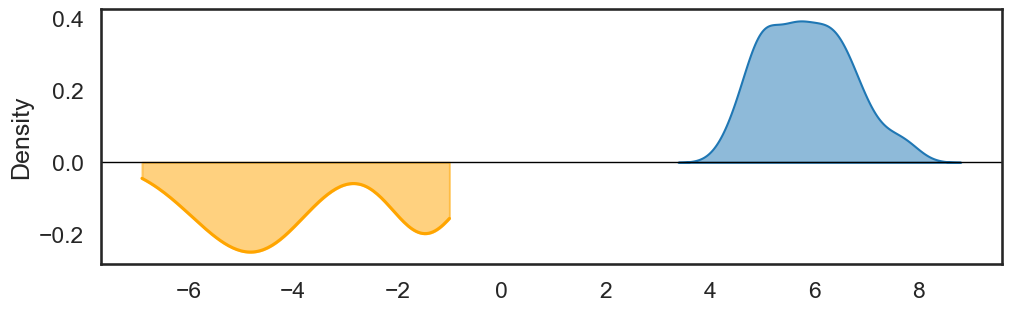

density_split


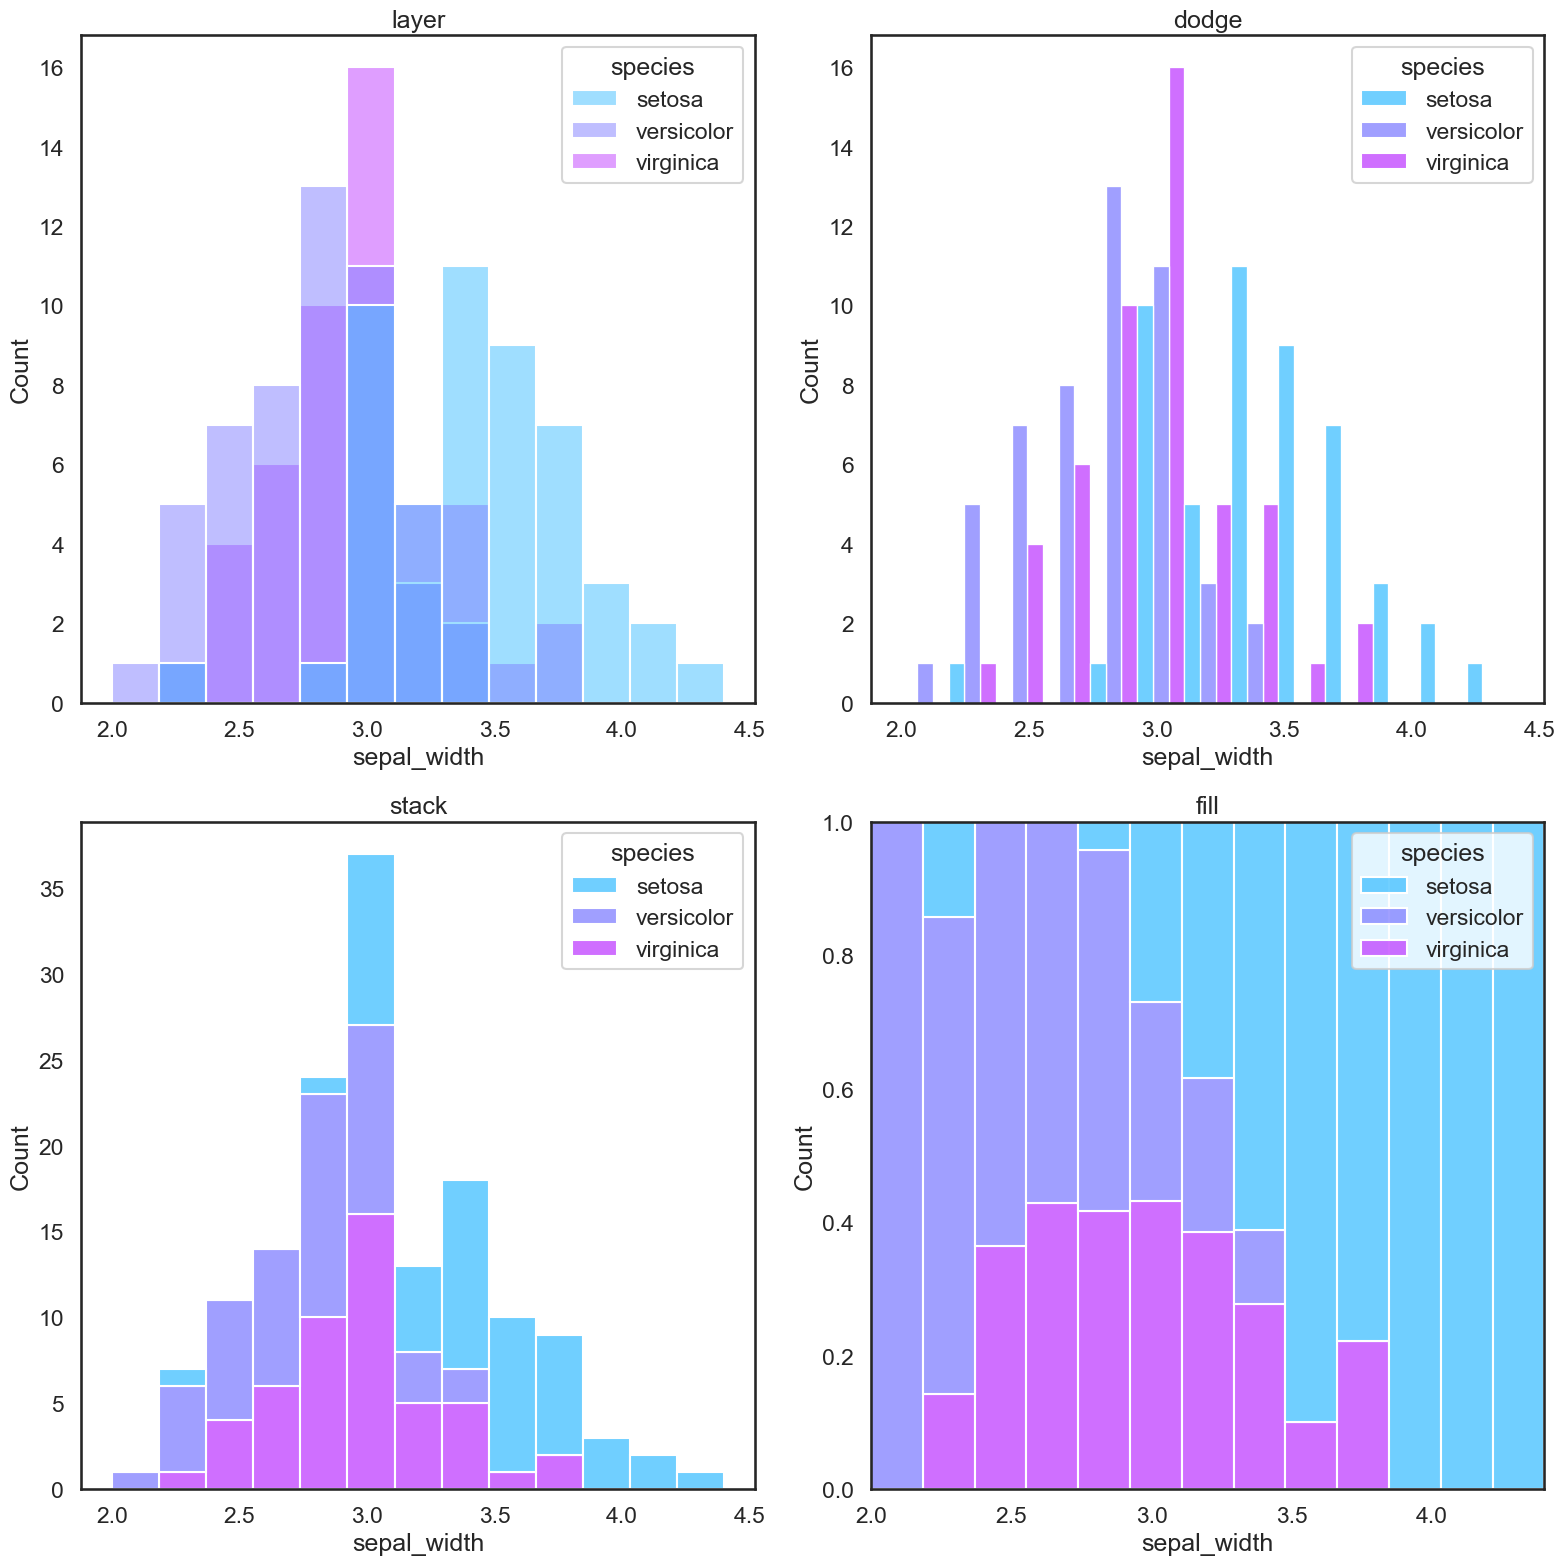

histogram_four


<Figure size 640x480 with 0 Axes>

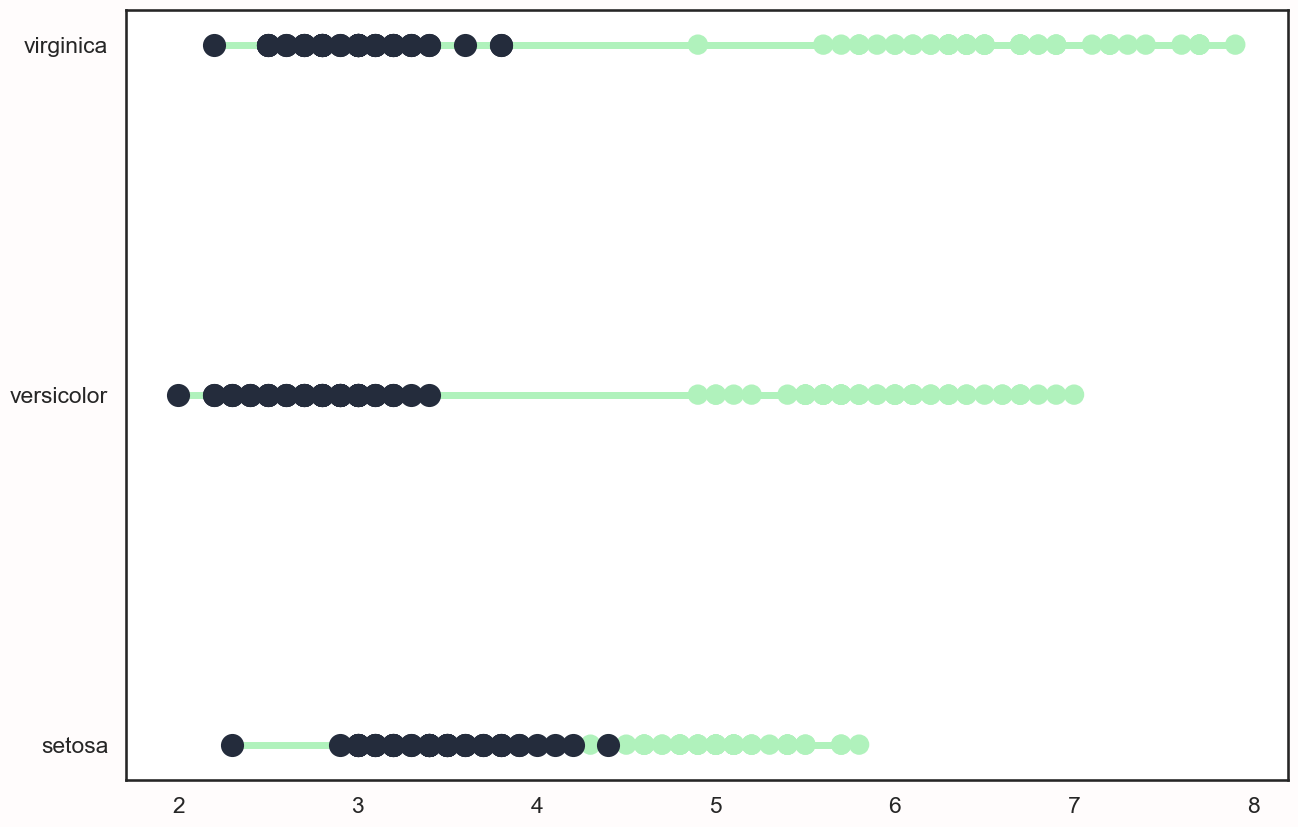

min2max


Loading BokehJS ...

area_stack


In [58]:
import matplotlib.pyplot as plt
import random

for i in range(len(viz_params_type)):
    tmp_viz = list(viz_params_type.keys())[i]
    
    num_list = list(tmp[(tmp['var_type']=='int') | (tmp['var_type']=='float')]['col_nm'].values)
    cat_list = list(tmp[tmp['var_type']=='category']['col_nm'].values)
    
    param_list = {}

    for j in range(len(viz_params_type[tmp_viz])):
        tmp_viz_params = list(viz_params_type[tmp_viz].keys())[j]

        try:
            if viz_params_type[tmp_viz][tmp_viz_params] == 'num':
                num_item = random.choice(num_list)
                param_list[tmp_viz_params] = num_item
                num_list.remove(num_item)
                # param_list[tmp_viz_params] = num_list[0]
                # num_list.remove(num_list[0])

            elif viz_params_type[tmp_viz][tmp_viz_params] == 'category':
                cat_item = random.choice(cat_list)
                param_list[tmp_viz_params] = cat_item
                num_list.remove(cat_item)
                # param_list[tmp_viz_params] = cat_list[0]
                # cat_list.remove(cat_list[0])

            else:
                pass
        except:
            pass

    method_name = func_list[i]
    method = getattr(test, method_name, None)  # 해당 메서드가 존재하는지 확인 후 가져오기

    if method:
        try:
            method(**param_list)
            print(method_name)
        except:
            plt.clf()
            pass
    else:
        print(f"Method '{method_name}' not found in the class.")